### Importing Dataset

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Public/Project resources/card_transdata.csv')

print(df.head())
print(df.info())
print(df.describe())

   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940                1          1   
1                        1.294219                1          0   
2                        0.427715                1          0   
3                        0.362663                1          1   
4                        2.222767                1          1   

   used_pin_number  online_order  fraud  
0                0             0      0  
1                0             0      0  
2                0             1      0  
3                0             1      0  
4                0             1      0  
<class 'pandas

Columns:
distance_from_home: Distance of the transaction from the cardholder’s home.
distance_from_last_transaction: Distance between this transaction and the last one.
ratio_to_median_purchase_price: Ratio of transaction value to the median purchase price for the cardholder.
repeat_retailer: Binary (1/0), whether the transaction occurred at a previously visited retailer.
used_chip: Binary (1/0), whether the transaction used a chip-enabled card.
used_pin_number: Binary (1/0), whether the transaction used a PIN.
online_order: Binary (1/0), whether the transaction was made online.
fraud: Binary target variable (1 for fraud, 0 for legitimate).

### Data Preprocessing

In [8]:
df['purchase_price_variance'] = df['ratio_to_median_purchase_price'].rolling(window=10).std().fillna(0)
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,purchase_price_variance
0,57.877857,0.311140,1.945940,1,1,0,0,0,0.000000
1,10.829943,0.175592,1.294219,1,0,0,0,0,0.000000
2,5.091079,0.805153,0.427715,1,0,0,1,0,0.000000
3,2.247564,5.600044,0.362663,1,1,0,1,0,0.000000
4,44.190936,0.566486,2.222767,1,1,0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1,1,0,0,0,0.699718
999996,19.872726,2.683904,2.778303,1,1,0,0,0,0.881344
999997,2.914857,1.472687,0.218075,1,1,0,1,0,0.928740
999998,4.258729,0.242023,0.475822,1,0,0,1,0,0.927975


In [10]:
from sklearn.preprocessing import StandardScaler

features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(df_scaled, columns=features)
df_scaled.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
0,0.477882,-0.182849,0.043491
1,-0.241607,-0.188094,-0.189300
2,-0.329369,-0.163733,-0.498812
3,-0.372854,0.021806,-0.522048
4,0.268572,-0.172968,0.142373


### Data Visualization

2. Exploratory Data Analysis (EDA)
Histograms:

Show feature distributions (e.g., distance values, ratio values).
Identify skewness or outliers in features like distance_from_home.
Heatmaps:

Correlation matrix between features to understand relationships and multicollinearity.
Count Plots:

Visualize the distribution of fraud (0 vs 1) to check dataset balance.

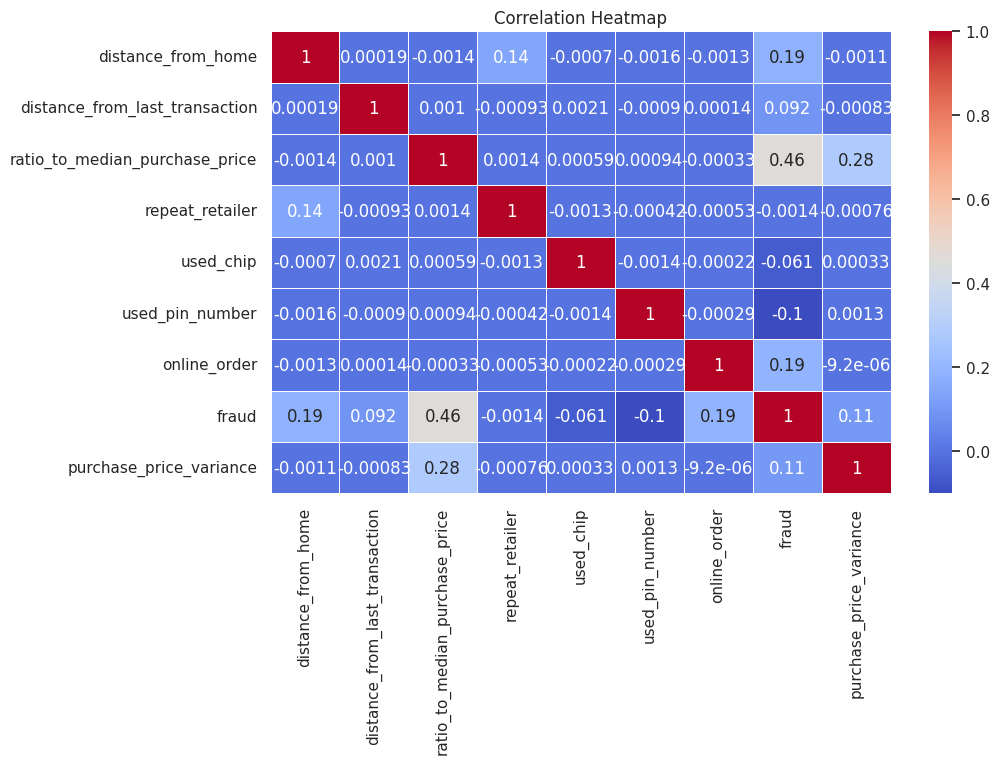

In [11]:
sns.set(style="whitegrid")
features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

<ipython-input-12-16ade8aee83d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraud', data=df, palette='Set1')


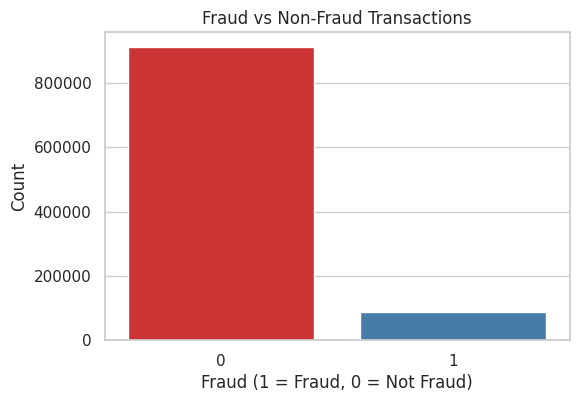

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='fraud', data=df, palette='Set1')
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('Fraud (1 = Fraud, 0 = Not Fraud)')
plt.ylabel('Count')
plt.show()

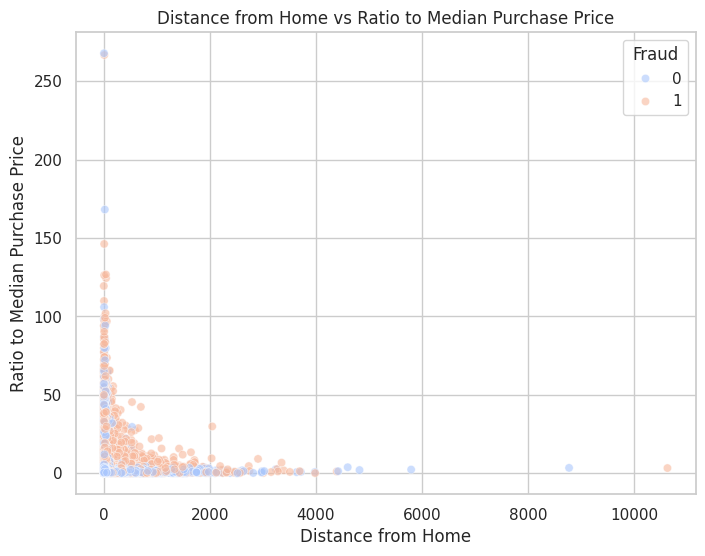

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='distance_from_home', y='ratio_to_median_purchase_price', hue='fraud', data=df, palette='coolwarm', alpha=0.6)
plt.title('Distance from Home vs Ratio to Median Purchase Price')
plt.xlabel('Distance from Home')
plt.ylabel('Ratio to Median Purchase Price')
plt.legend(title='Fraud')
plt.show()

### Clustering for Risk Segmentation

3. Clustering
Purpose: Unsupervised detection of patterns and grouping transactions.

Methods:

K-means clustering:
Groups transactions into clusters based on their feature values.
Used the Elbow Method to determine the optimal number of clusters.
DBSCAN:
Detects density-based clusters and marks sparse data points as anomalies (-1 label).
Correlated anomalies with fraud for validation.
Visualizations:

Scatter plots showing clusters with distinct colors.

In [14]:
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_scaled['cluster'] = kmeans.fit_predict(df_scaled)

df['cluster'] = df_scaled['cluster']

df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'cluster']].head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,cluster
0,57.877857,0.311140,1.945940,0
1,10.829943,0.175592,1.294219,0
2,5.091079,0.805153,0.427715,0
3,2.247564,5.600044,0.362663,0
4,44.190936,0.566486,2.222767,0


In [15]:
print("Cluster Centers:")
print(kmeans.cluster_centers_)
print("Inertia (Sum of Squared Distances):", kmeans.inertia_)

Cluster Centers:
[[-8.75872498e-02 -3.63783967e-04 -1.72047791e-01]
 [ 5.45395158e+00 -2.53881575e-03 -6.93651917e-02]
 [-7.23205845e-02  7.16488466e-03  3.05329059e+00]]
Inertia (Sum of Squared Distances): 2006466.4612336664


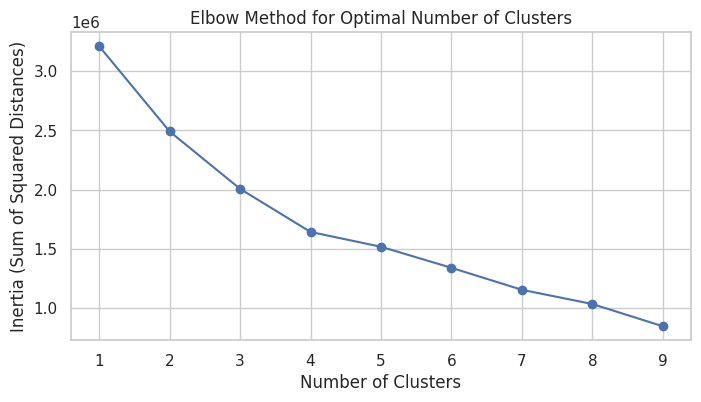

In [16]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()

# Risk Scoring

4. Risk Scoring
Objective: Assign a numerical risk score to each transaction.
Features Used:
Weighted combination of distance_from_home, distance_from_last_transaction, ratio_to_median_purchase_price, and binary attributes like used_chip.
Categories:
Low Risk, Medium Risk, and High Risk based on thresholds.
Key Insights:
Fraud transactions tend to have higher risk scores.


In [17]:
weights = {
    'distance_from_home': 0.35,  # Slightly increased
    'distance_from_last_transaction': 0.25,  # Slightly increased
    'ratio_to_median_purchase_price': 0.3,  # Unchanged
    'repeat_retailer': 0.05,  # Slightly decreased
    'used_chip': 0.025,  # Reduced
    'online_order': 0.025,  # Reduced
    'used_pin_number': 0.025  # Reduced
}

df = df.fillna(0)  # Replace missing values with 0


df['risk_score'] = (df['distance_from_home'] * weights['distance_from_home'] +
                    df['distance_from_last_transaction'] * weights['distance_from_last_transaction'] +
                    df['ratio_to_median_purchase_price'] * weights['ratio_to_median_purchase_price'] +
                    (df['repeat_retailer'] == 0) * weights['repeat_retailer'] +  # Non-repeat retailer
                    (df['used_chip'] == 0) * weights['used_chip'] +              # No chip used
                    (df['online_order'] == 1) * weights['online_order'] +        # Online order
                    (df['used_pin_number'] == 0) * weights['used_pin_number'])   # No PIN used


df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'risk_score']].head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,risk_score
0,57.877857,0.311140,1.945940,20.943817
1,10.829943,0.175592,1.294219,4.272643
2,5.091079,0.805153,0.427715,2.186480
3,2.247564,5.600044,0.362663,2.345457
4,44.190936,0.566486,2.222767,16.325279


In [18]:
LOW_RISK_THRESHOLD = 3
MEDIUM_RISK_THRESHOLD = 6

def categorize_risk(score):
    if score < LOW_RISK_THRESHOLD:
        return 'Low Risk'
    elif LOW_RISK_THRESHOLD <= score < MEDIUM_RISK_THRESHOLD:
        return 'Medium Risk'
    else:
        return 'High Risk'

df['risk_category'] = df['risk_score'].apply(categorize_risk)
df[['risk_score', 'risk_category']].head()

,risk_score,risk_category
0,20.943817,High Risk
1,4.272643,Medium Risk
2,2.186480,Low Risk
3,2.345457,Low Risk
4,16.325279,High Risk


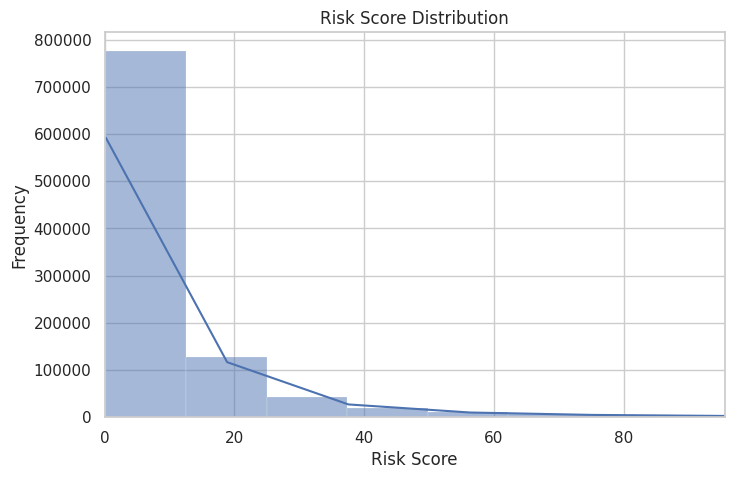

<ipython-input-19-10a28b9f4482>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='risk_category', data=df, palette='Set2', order=['Low Risk', 'Medium Risk', 'High Risk'])


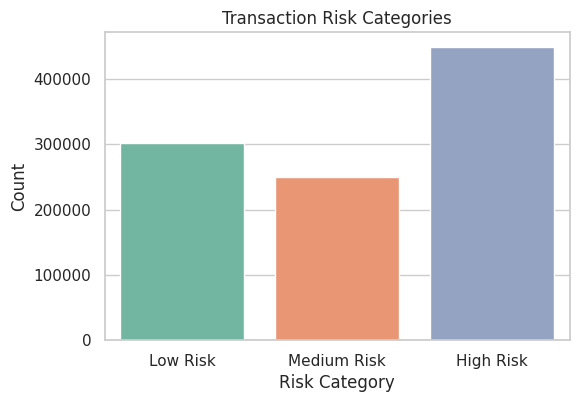

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(df['risk_score'], kde=True, bins=300)
plt.title('Risk Score Distribution')
plt.xlim(0, df['risk_score'].quantile(0.99))
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='risk_category', data=df, palette='Set2', order=['Low Risk', 'Medium Risk', 'High Risk'])

plt.title('Transaction Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.show()

   fraud  risk_score
0      0    9.553720
1      1   28.244764


<ipython-input-20-ba515e96f7b9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fraud', y='risk_score', data=risk_summary, palette='Set1')


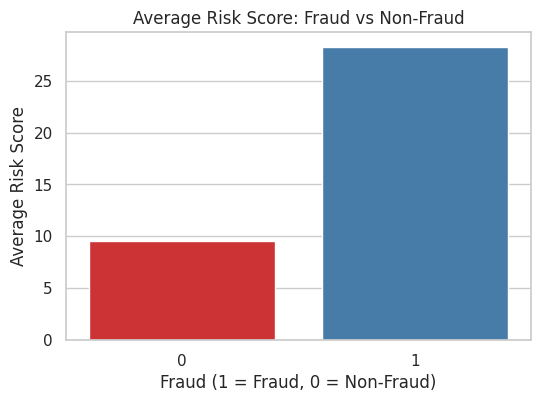

In [20]:
risk_summary = df.groupby('fraud')['risk_score'].mean().reset_index()
print(risk_summary)

plt.figure(figsize=(6, 4))
sns.barplot(x='fraud', y='risk_score', data=risk_summary, palette='Set1')
plt.title('Average Risk Score: Fraud vs Non-Fraud')
plt.xlabel('Fraud (1 = Fraud, 0 = Non-Fraud)')
plt.ylabel('Average Risk Score')
plt.show()

### Machine Learning Model

5. Fraud Detection (Supervised Learning)
Models Used:

Random Forest: To classify transactions as fraudulent or not.
Logistic Regression: A simpler baseline model.

Evaluation Metrics:

Accuracy, precision, recall, F1-score.
Confusion Matrix:

Showcased classification results.

In [21]:
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,purchase_price_variance,cluster,risk_score,risk_category
0,57.877857,0.311140,1.945940,1,1,0,0,0,0.000000,0,20.943817,High Risk
1,10.829943,0.175592,1.294219,1,0,0,0,0,0.000000,0,4.272643,Medium Risk
2,5.091079,0.805153,0.427715,1,0,0,1,0,0.000000,0,2.186480,Low Risk
3,2.247564,5.600044,0.362663,1,1,0,1,0,0.000000,0,2.345457,Low Risk
4,44.190936,0.566486,2.222767,1,1,0,1,0,0.000000,0,16.325279,High Risk
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1,1,0,0,0,0.699718,0,1.313687,Low Risk
999996,19.872726,2.683904,2.778303,1,1,0,0,0,0.881344,0,8.484921,High Risk
999997,2.914857,1.472687,0.218075,1,1,0,1,0,0.928740,0,1.503794,Low Risk
999998,4.258729,0.242023,0.475822,1,0,0,1,0,0.927975,0,1.768808,Low Risk


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

X = df.drop(['fraud','risk_category','cluster','risk_score','purchase_price_variance'], axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else 'N/A'

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

log_reg = LogisticRegression(random_state=42)

log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]  # For ROC-AUC

print("Logistic Regression Results:")
evaluate_model(y_test, y_pred_lr, y_pred_proba_lr)

Logistic Regression Results:
Accuracy: 0.9587
Precision: 0.8915
Recall: 0.6001
F1-Score: 0.7173
ROC-AUC: 0.9669


In [25]:
rf_clf = RandomForestClassifier(random_state=42)

rf_clf.fit(X_train_scaled, y_train)

y_pred = rf_clf.predict(X_test_scaled)


In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[182557      0]
 [     2  17441]]


Dataset in Muskan Public Project Drive

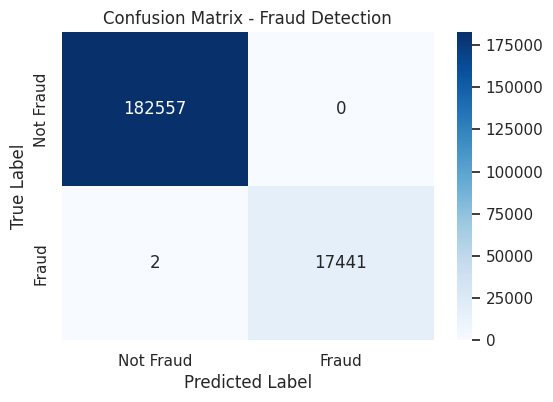

In [27]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Fraud Detection')
plt.show()

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    182557
       Fraud       1.00      1.00      1.00     17443

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



DBSCAN

6. Anomaly Detection
DBSCAN:
Marked transactions with unusual patterns as anomalies.
Fraud Correlation:
Checked if anomalies (DBSCAN label = -1) have a higher proportion of fraud compared to regular transactions.

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

dbscan_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

scaler = StandardScaler()
dbscan_data = scaler.fit_transform(df[dbscan_features])


In [ ]:

dbscan = DBSCAN(eps=1.5, min_samples=5)

dbscan_labels = dbscan.fit_predict(dbscan_data)

df['dbscan_label'] = dbscan_labels


In [ ]:
# Plot anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_from_home', y='ratio_to_median_purchase_price', hue='dbscan_label',
                data=df, palette='coolwarm', alpha=0.6)
plt.title('DBSCAN: Distance from Home vs Ratio to Median Purchase Price')
plt.xlabel('Distance from Home')
plt.ylabel('Ratio to Median Purchase Price')
plt.legend(title='DBSCAN Label')
plt.show()


In [ ]:
# Calculate the proportion of anomalies and their fraud correlation
anomalies = df[df['dbscan_label'] == -1]
normal_points = df[df['dbscan_label'] != -1]

print("Proportion of Anomalies:", len(anomalies) / len(df))
print("Fraud in Anomalies:", anomalies['fraud'].mean())
print("Fraud in Normal Points:", normal_points['fraud'].mean())

# Compare fraud rates between anomalies and normal points
plt.figure(figsize=(6, 4))
sns.barplot(x=['Anomalies', 'Normal Points'], y=[anomalies['fraud'].mean(), normal_points['fraud'].mean()])
plt.title('Fraud Proportion: Anomalies vs Normal Points')
plt.ylabel('Fraud Rate')
plt.show()
